In [11]:
%matplotlib widget
from pathlib import Path

import numpy as np
import scipy.signal as sps

from spectrometer import FID1D, process
from spectrometer.process import decaying_sinus

cm = 1 / 2.54

In [12]:
# Load raw *.fid data
file = Path(
    "../data/20230906-172617-Toluene-1H-single_90_degree_pulse,length=8us,delay=25us,record_length=15000.0,sample_rate=320000.0,probe=andrew.fid"
)
fid = FID1D.from_file(file)

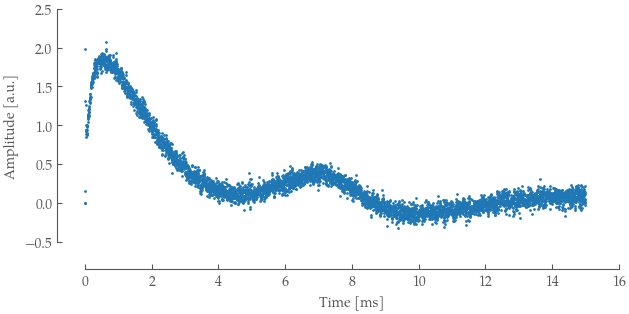

In [13]:
# Plot raw data
fig = fid.plot(
    figsize=(16.0 * cm, 8.0 * cm)  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
fig.savefig("fid_toluene.pdf")

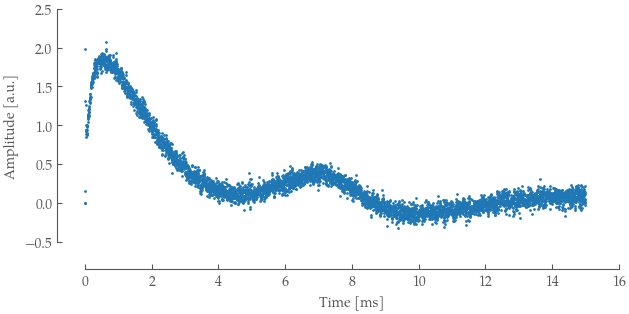

In [14]:
# Try fitting the envelope
try:
    # Plot raw data
    fig = fid.plot(
        figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
    )
    axes = fig.axes[0]

    envelope = np.abs(sps.hilbert(fid.real))
    fit_exp_decay = process.exp_decay.fit(fid.ms_scale, envelope)
    ms_scale_fine = np.linspace(
        fid.ms_scale[0], fid.ms_scale[-1], len(fid.ms_scale) * 10
    )
    axes.plot(
        ms_scale_fine,
        fit_exp_decay(ms_scale_fine),
        linestyle="--",
    )

    # Try fitting the absolute directly
    fit_abs = process.exp_decay.fit(fid.ms_scale, fid.absolute)
    axes.plot(
        ms_scale_fine,
        fit_abs(ms_scale_fine),
        linestyle=":",
    )
except RuntimeError:
    pass

fig.savefig("fid_toluene_envelope_fit.pdf")

In [15]:
# Try to plot simple least squares fit for a decaying sinusoid
decaying_sinus_fit = decaying_sinus.fit(fid.ms_scale, fid.real)
ms_scale_fine = np.linspace(fid.ms_scale[0], fid.ms_scale[-1], len(fid.ms_scale) * 10)
print(decaying_sinus_fit)

# Plot raw
fig = fid.plot(figsize=(16 * cm, 8 * cm))  # Wide Layout: ~16cm, Margin Layout: 10.7cm

# Plot fit
fig.axes[0].plot(
    ms_scale_fine,
    decaying_sinus_fit(ms_scale_fine),
    linestyle="--",
)

fig.savefig("fid_toluene_sine_fit.pdf")

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

Phase Shift: -16.99107812500002


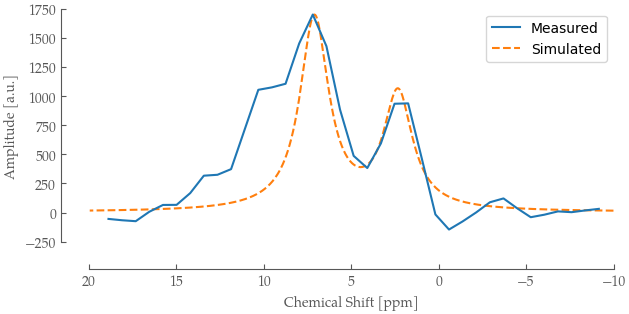

In [17]:
# Measured Spectrum
fid.carrier_freq = 200  # Manually adjust shift (there's no locking yet)
fid.data = fid[5:]  # Crop beginning
spectrum, p0 = fid.spectrum()  # phase_shift_kwargs={"p0": 350})
print(f"Phase Shift: {p0}")

peak_spectrum = spectrum.ppm.crop(-10, 19)  # minimize whitespace
peak_fig = peak_spectrum.ppm.plot(
    figsize=(16 * cm, 8 * cm), linestyle="-", markersize=0, label="Measured"
)

# Load simulated spectrum
# B_0 = 25MHz, Linewidth = 50Hz, Simulated with MestReNova 14.3.3
toluene = np.loadtxt("../data/toluene_simulation_25MHz_field_50Hz_linewidth.csv")
ppm_scale, fft = toluene[:-1, 0], toluene[:-1, 1]
scale = np.max(spectrum.real) / np.max(fft.real)  # Scale maximum to fit measured data
peak_fig.axes[0].plot(
    ppm_scale, fft.real * scale, linestyle="--", label="Simulated", zorder=-1
)

# plot.format_axes(axes)
peak_fig.axes[0].invert_xaxis()
peak_fig.axes[0].legend()
peak_fig.savefig("fft_toluene.pdf")

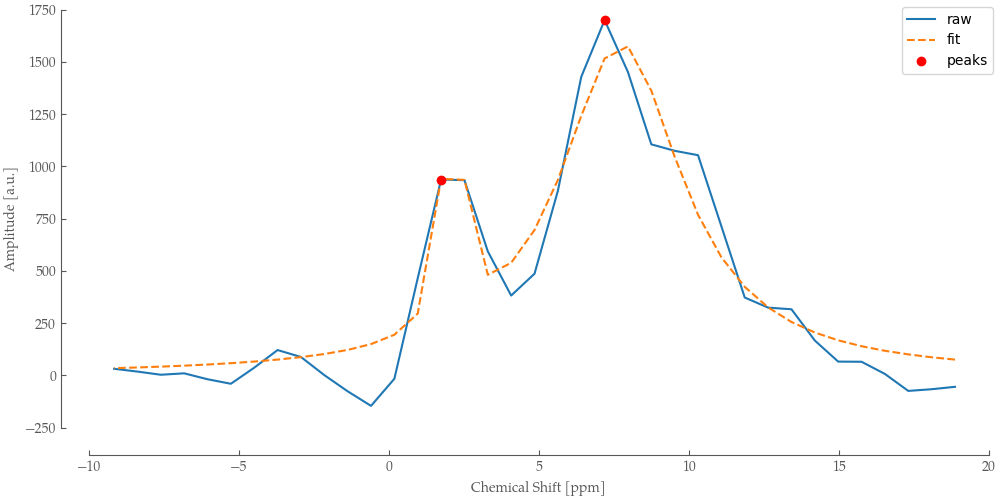

In [18]:
# Perform least squared fit of a lorentzian mixture on detected peaks above 3*noise threshold
fit_spectrum, fitpeaks = peak_spectrum.ppm.fit()
peaks = peak_spectrum.ppm.peaks()

# Plot
fig = peak_spectrum.ppm.plot(linestyle="-", marker="", label="raw")
fig.axes[0].plot(peak_spectrum.ppm.scale, fit_spectrum, linestyle="--", label="fit")
fig.axes[0].plot(
    [peak.location for peak in peaks],
    [peak.amplitude.real for peak in peaks],
    linestyle="",
    marker="o",
    color="red",
    label="peaks",
)
fig.legend()